In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt 
%matplotlib inline 

In [17]:
num_steps = 10
batch_size = 200 
num_classes = 2
state_size = 16
learning_rate = 0.1 

## Data Generation 

In [3]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5 
        if X[i-3] == 1:
            threshold += 0.5 
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data 
    data_length = len(raw_x)
    
    batch_partition_length = data_length // batch_size 
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i: batch_partition_length * (i+1)]
        data_y[i] = raw_y[batch_partition_length * i: batch_partition_length * (i+1)]
    
    epoch_size = batch_partition_length // num_steps
    
    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i+1) * num_steps]
        y = data_y[:, i * num_steps:(i+1) * num_steps]
        yield (x, y)
        
def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

## Model

In [4]:
x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

# RNN Inputs 
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

# rnn inputs as a list of a number (batch size) of one hot vectors 

In [11]:
# Definition of rnn_cell 

with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    
def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

In [12]:
# Adding rnn_cells to graph 

state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

In [14]:
# Prediction, loss, training step 

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

y_as_list = tf.unstack(y, num=num_steps, axis=1)

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for 
         logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step =  tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [15]:
# Train the network 

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses, total_loss, final_state, train_step],
                            feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step, 
                             "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0
    return training_losses 


EPOCH 0
Average loss at step 100 for last 250 steps: 0.594163248539
Average loss at step 200 for last 250 steps: 0.521576545238
Average loss at step 300 for last 250 steps: 0.521482703388
Average loss at step 400 for last 250 steps: 0.519919075072

EPOCH 1
Average loss at step 100 for last 250 steps: 0.525433504879
Average loss at step 200 for last 250 steps: 0.519083153903
Average loss at step 300 for last 250 steps: 0.520424753129
Average loss at step 400 for last 250 steps: 0.520264916122

EPOCH 2
Average loss at step 100 for last 250 steps: 0.523283072114
Average loss at step 200 for last 250 steps: 0.521473294199
Average loss at step 300 for last 250 steps: 0.519357462525
Average loss at step 400 for last 250 steps: 0.520110862553

EPOCH 3
Average loss at step 100 for last 250 steps: 0.526946133077
Average loss at step 200 for last 250 steps: 0.518657598495
Average loss at step 300 for last 250 steps: 0.522180112302
Average loss at step 400 for last 250 steps: 0.51898521632

EPOC

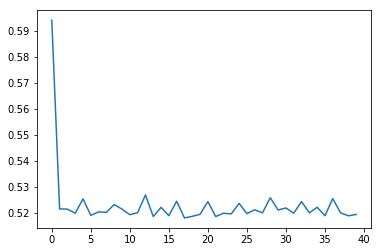

In [18]:
training_losses = train_network(10, num_steps)
plt.plot(training_losses)

## Play with hyperparameters 

In [28]:
# This is non-sense 
import basic_rnn 
def plot_learning_curve(num_steps, state_size=4, epochs=1):
    global losses, total_loss, final_state, train_step, x, y, init_state
    tf.reset_default_graph()
    g = tf.get_default_graph()
    losses, total_loss, final_state, train_step, x, y, init_state = \
        basic_rnn.setup_graph(g, 
            basic_rnn.RNN_config(num_steps=num_steps, state_size=state_size))
    res = train_network(epochs, num_steps, state_size=state_size, verbose=False)
    plt.plot(res)

In [29]:
""" 
NUM_STEPS = 1
"""
plot_learning_curve(num_steps=1, state_size=4, epochs=2)

TypeError: Input 'split_dim' of 'Split' Op has type float32 that does not match expected type of int32.

## The above is deprecated !

# TensorFlow API Version

### Static RNN 

In [ ]:
# replace definition of rnn_cell & adding rnn_cells to graph into the following 

cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=init_state)

### Dynamic RNN

In [ ]:
# dynamic RNN construction is preferred over static construction 

# replace the following 
# x_one_hot = tf.one_hot(x, num_classes)
# rnn_inputs = tf.unstack(x_one_hot, axis=1)
rnn_inputs = tf.one_hot(x, num_classes)

# replace definition of rnn_cell & adding rnn_cells to graph into the following 
cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_input, initial_state=init_state)

# replace the following 
# logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
# predictions = [tf.nn.softmax(logit) for logit in logits]

# y_as_list = tf.unstack(y, num=num_steps, axis=1)

# losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
#           logit, label in zip(logits, y_as_list)]
# total_loss = tf.reduce_mean(losses)
# train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)
logits = tf.reshape(
            tf.matmul(tf.reshape(rnn_outputs, [-1, state_size]), W) + b,
            [batch_size, num_steps, num_classes])
predictions = tf.nn.softmax(logits)

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)